# The Capstone - Predicting traffic collision severity

**This is the final project for the data science course: It is only a testing project, no real results and outputs are generated thus the developed models should not be used for any interpretation!**

## Introduction

### Background

![WHO](https://www.who.int/violence_injury_prevention/road_safety_status/2018/CAR-2.gif?ua=1)

**Road traffic crashes** are globally among the leading causes of death and even exceed serious diseases such as HIV/AIDS [1]. The number of killed persons due to traffic crashes is estimated to be around **1.35 million** while less protected traffic participants such as pedestrians or cyclist are most affected. High-income countries count for high usage of vehicles; however, fatal rate is 3 times lower than in low-income countries but still – morbidity and mortality due to traffic crashes remain high and globally represent a high **social, health and economic burden**. In the global status report on road safety the WHO states an unacceptably high number of deaths on the world’s roads [2]. Governments all over the world have taken several (legislative) measures to minimize behavioural risk factors such as speed and drink-driving, or to improve road infrastructure and vehicles safety, thus decreasing the occurrence of road traffic collisions. At the same time, methods to prevent fatal outcome in road traffic collision are taken (e.g. helmets or seatbelts). Post-crash care is another crucial factor in minimizing mortality and morbidity in traffic crashes, but highly dependent on available resources which explains the discrepancy between low- and high-income countries in providing prehospital care. The evidence-based guideline *Save LIVES: a road safety technical package* has been provided by the WHO for decision-makers to reduce road traffic deaths [3]. The acronym **LIVES** sets the focus on the interventions speed management, **L**eadership, **I**nfrastructure design, **V**ehicle safety, **E**nforcement of traffic laws and post-crash **S**urvival.

___

*References*

   [1] Peden M, Scurfield R, Sleet D, Mohan D, Hyder AA, Jarawan E, et al.: World report on road traffic injury prevention. Geneva 2004.  
   [2] World Health Organization (WHO): Global status report on road safety 2018. Geneva 2018.  
   [3] World Health Organization (WHO): Save LIVES: A road safety technical package. Geneva: World Health Organization Copyright 2017.



### Rationale
In the context of globally rising motorization of transport and the **SDG target** to decrease road traffic deaths to 50 % by 2020, further research should be performed to find factors with enormous potential impact. This project aims to re-evaluate and identify factors leading to a high severity in collisions with serious and/or fatal injuries, and to describe the prediction strength. A prediction model on collision severity is also needed to efficiently distribute the limited resources of emergency health care to the places where needed the most.  
Such a model enables decision-makers to 
* focus on most efficient preventive strategies
* to allocate limited health care resources and
* to provide a risk assessment for individual considerations as a traffic participant

By doing so a range of stakeholders such as **politicians, emergency health care managers, physicians and individual representatives of traffic participants** should be addressed in the evaluation process.

As there already exists evidence and good research regarding factors contributing to the probability of a traffic collision and different measures are taken to reduce the risk (see *Save LIVES*), this project focuses on the aspect of distributing the limited resources of emergency health care to the right places thus concentrating on severity-related factors which are observed without in-depth investigation and available as information for the **health care decision-makers**.


## Data understanding

### Data source
The data used to build this model is provided by the **Seattle Department of Transportation** which is the official governmental department focusing on transportation systems and providing safe access to places in Seattle. The dataset consists of all types of collisions from 2004 on combined with several attributes such as weather, road or light condition, involved traffic participants, infrastructural aspects and geographical data. Some of the attributes have already been linked to the occurrence of traffic collisions (e.g. speeding, weather, road or light condition) and will now be used to evaluate the collision severity. The latter is labelled by a severity code ranging from **1 (property damage only) to 3 (fatality)** in the provided dataset. Attributes of interest to predict severity in the first place without further in-depth assessment include the following points while individual factors which need further investigation such as inattention or drink-driving and the specific location were excluded.
+ involvement of **vulnerable traffic participants**: pedestrians, bicycles
+ **infrastructural** factors: junction type, road condition, pedestrian right of way, speeding
+ **environmental** factors: weather condition, light condition  

Being able to include the contextual data of a traffic collision into the model will ensure a comprehensive assessment of potential influencing factors. The choice of factors may enable conclusions for a more general setting without time or location specific data.

### Pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import missingno as msno
import matplotlib.pyplot as plt

import scipy as sc
from scipy import stats as stats
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.utils import resample

nl = '\n'

In [2]:
path = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(path)
df.shape

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(194673, 38)

In [3]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

#### Defining target variable

The target variable – the severity of traffic collisions (SEVERITYCODE) – was assessed and due to the limitation of its dimensions to 1 (‘property damage only’) and 2 (‘injury’) defined as a binary variable (Y_SEVERITYCODE).

In [5]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [6]:
def set_severity(row):
    if (row['SEVERITYCODE'] == 1):
        return "Property damage only"
    else:
        return "Injury"
df = df.assign(Y_SEVERITYCODE=df.apply(set_severity, axis=1))    

In [7]:
df['Y_SEVERITYCODE'].value_counts(normalize=True)

Property damage only    0.701099
Injury                  0.298901
Name: Y_SEVERITYCODE, dtype: float64

#### Missing data analysis

As one of the first steps the dataset was reviewed with regard to its integrity. Missing values were obtained by exploring the respective columns, marking ‘Unknown’, ‘0’ or any other possible missing value to NaN. 

In [8]:
df = df.replace('Unknown', np.nan)

To get an idea of the missing mechanism a graphical approach via heatmaps and dendrogram was applied which revealed correlations between the missing rate of linked attributes. 

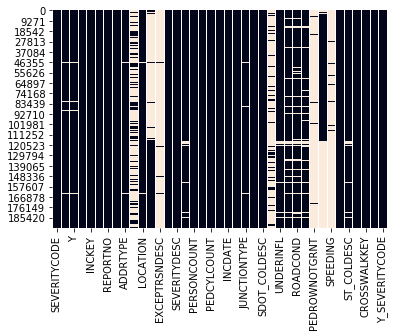

In [10]:
sb.heatmap(df.isnull(), cbar=False)

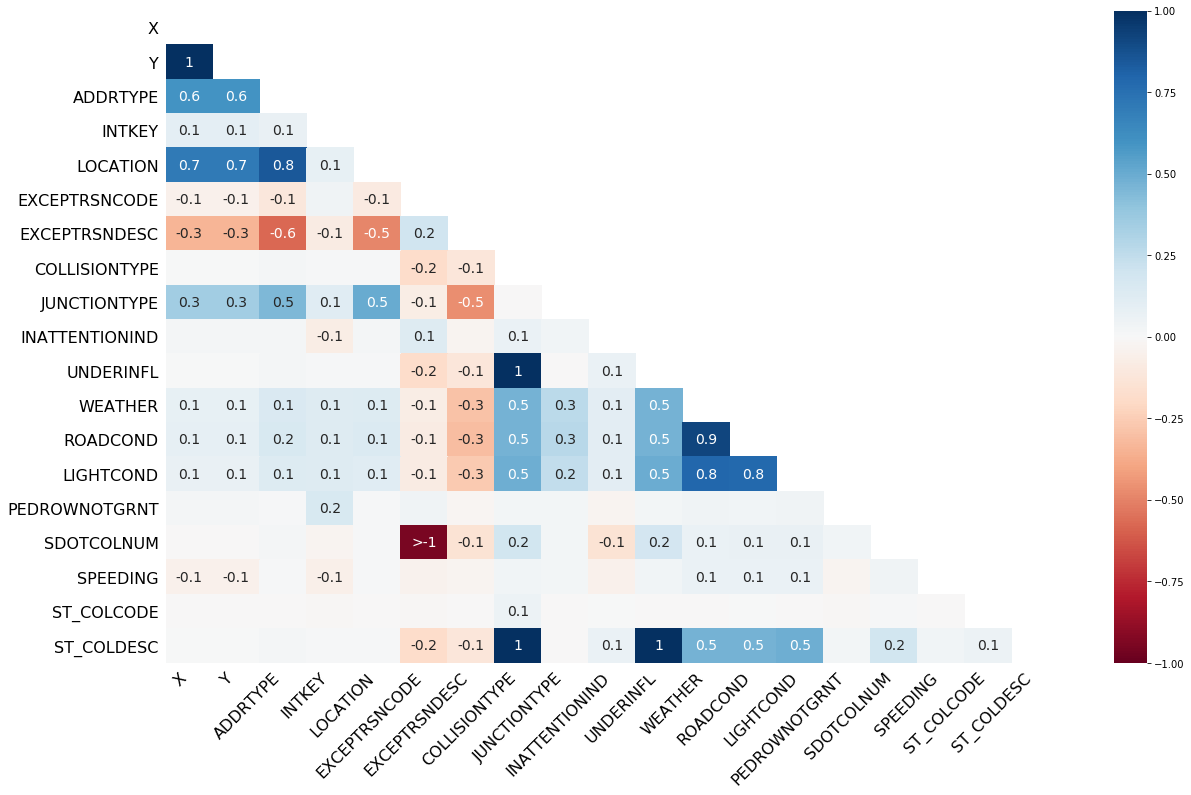

In [14]:
msno.heatmap(df)

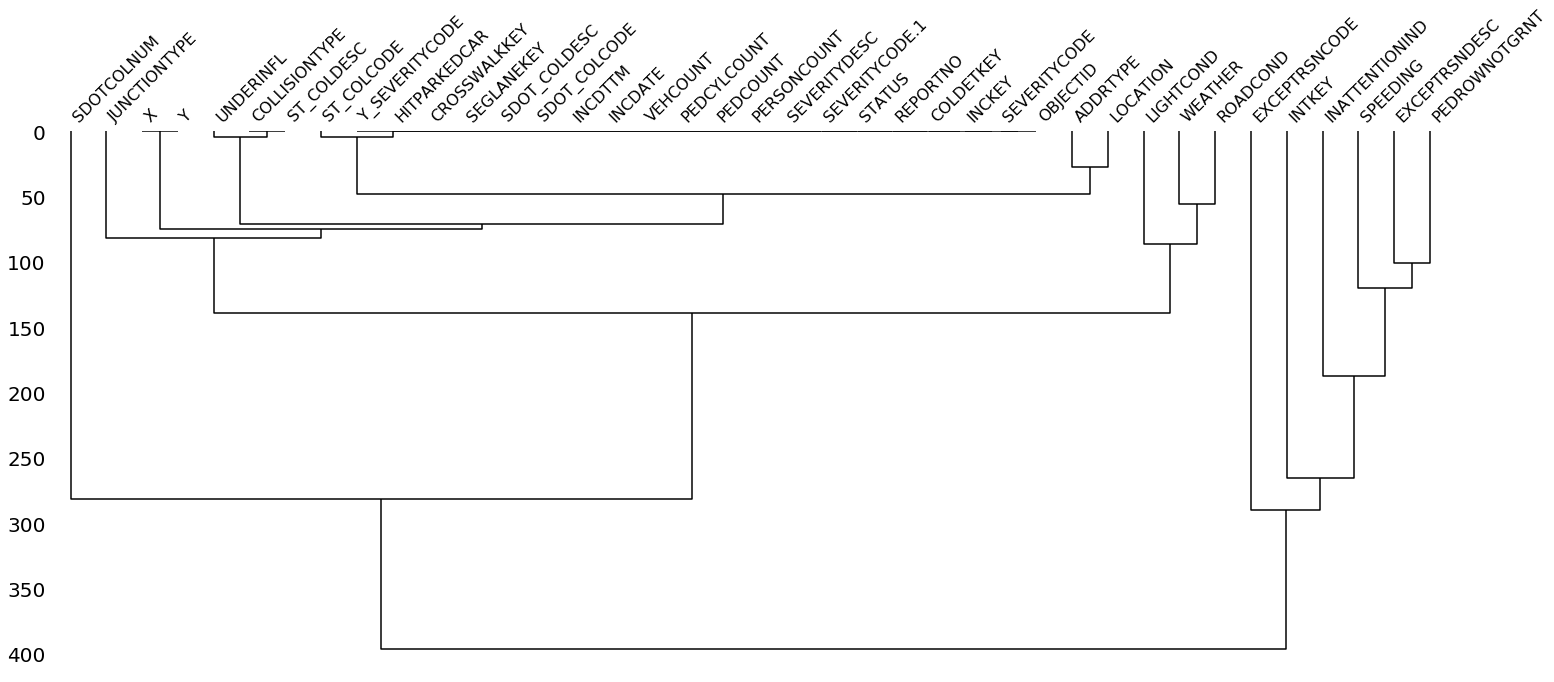

In [11]:
msno.dendrogram(df)

In [12]:
missing=df.isnull()

In [13]:
for column in missing:
    print(missing[column].value_counts(normalize=True),nl)

False    1.0
Name: SEVERITYCODE, dtype: float64 

False    0.9726
True     0.0274
Name: X, dtype: float64 

False    0.9726
True     0.0274
Name: Y, dtype: float64 

False    1.0
Name: OBJECTID, dtype: float64 

False    1.0
Name: INCKEY, dtype: float64 

False    1.0
Name: COLDETKEY, dtype: float64 

False    1.0
Name: REPORTNO, dtype: float64 

False    1.0
Name: STATUS, dtype: float64 

False    0.990106
True     0.009894
Name: ADDRTYPE, dtype: float64 

True     0.665747
False    0.334253
Name: INTKEY, dtype: float64 

False    0.986249
True     0.013751
Name: LOCATION, dtype: float64 

True     0.564341
False    0.435659
Name: EXCEPTRSNCODE, dtype: float64 

True     0.971039
False    0.028961
Name: EXCEPTRSNDESC, dtype: float64 

False    1.0
Name: SEVERITYCODE.1, dtype: float64 

False    1.0
Name: SEVERITYDESC, dtype: float64 

False    0.974809
True     0.025191
Name: COLLISIONTYPE, dtype: float64 

False    1.0
Name: PERSONCOUNT, dtype: float64 

False    1.0
Name: PEDCOUNT, 

Attributes with missing rates of more than or equal to 5 % were looked at in more detail. The affected variables (missing rate in brackets) included
+ INTKEY (66.58 %)
+ EXCEPTRSNCODE (56.43 %)
+ EXCEPTRSNDESC (97.10 %)
+ INATTENTIONIND (84.69 %)
+ PEDROWNOTGRNT (97.60 %)
+ SDOTCOLNUM (40.96 %)
+ SPEEDING (95.23 %)
+ WEATHER (10.36 %)
+ ROADCOND (10.32 %)
+ LIGHTCOND (9.58 %)   

To get an idea of the missing mechanism a graphical approach via heatmaps and dendrogram was applied which revealed correlations between the missing rate of linked attributes. When grouping the missing rates by the target variable no significant difference between these groups could be detected via chi2-testing. 

In [15]:
Outcome=df['Y_SEVERITYCODE']
Outcome=Outcome.rename('Y_SEVERITYCODE_Y')
Var = ['INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 
       'SPEEDING', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
missing_5_percent=missing[Var]
missing_df=pd.concat([missing_5_percent, Outcome], axis=1)
for column in missing_df:
    crosstab_miss = pd.crosstab(missing_df[column],missing_df.Y_SEVERITYCODE_Y,normalize='columns',margins=True, margins_name='Total')
    print(crosstab_miss,nl)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab_miss)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

Y_SEVERITYCODE_Y    Injury  Property damage only     Total
INTKEY                                                    
False             0.478088              0.272931  0.334253
True              0.521912              0.727069  0.665747 

Chi2 value= 0.09606125393968755
p-value= 0.9531045959247714
Degrees of freedom= 2

Y_SEVERITYCODE_Y    Injury  Property damage only     Total
EXCEPTRSNCODE                                             
False             0.464838              0.423219  0.435659
True              0.535162              0.576781  0.564341 

Chi2 value= 0.0037022920649422953
p-value= 0.9981505662816015
Degrees of freedom= 2

Y_SEVERITYCODE_Y    Injury  Property damage only     Total
EXCEPTRSNDESC                                             
False             0.008851              0.037535  0.028961
True              0.991149              0.962465  0.971039 

Chi2 value= 0.01770832493791289
p-value= 0.9911849201944142
Degrees of freedom= 2

Y_SEVERITYCODE_Y    Injury  Propert

Taking these considerations into account there seems not be a missing mechanism completely at random (MCAR) but rather missing at random (**MAR**). These assumptions need to be considered in case of further pre-processing and handling missing data. 

### Feature selection

The original dataset consisted of 38 columns, during feature selection the columns were reduced to a relevant number of 9. The feature selection involved several steps: Identifier parameters such as chosen IDs or report numbers were removed, doubly-present (redundant) variables were removed, some variables of interest were aggregated and updated, and time- or location-specific data was excluded from the analysis.

#### Removing identifier parameters

In [16]:
df_1 = df.drop(['REPORTNO', 'OBJECTID', 'INCKEY','COLDETKEY','INTKEY','SDOTCOLNUM','STATUS'], axis=1)

#### Re-defining variables of interest 

In [17]:
df_1['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Name: JUNCTIONTYPE, dtype: int64

In [18]:
def set_junction(row):
    if (row['JUNCTIONTYPE'] == 'Mid-Block (not related to intersection)')|(row['JUNCTIONTYPE'] == 'At Intersection (but not related to intersection)'):
        return "Y"
    else:
        return "N"
df_1 = df_1.assign(JUNCTION=df_1.apply(set_junction, axis=1))  

In [19]:
df_1['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [20]:
def set_weather(row):
    if (row['WEATHER'] == 'Overcast')|(row['WEATHER'] == 'Partly Cloudy'):
        return "Cloudy"
    elif (row['WEATHER'] == 'Clear'):
        return "Clear"
    elif (row['WEATHER'] == 'Raining')|(row['WEATHER'] == 'Snowing')|(row['WEATHER'] == 'Sleet/Hail/Freezing Rain'):
        return "Precipitation"
    elif (row['WEATHER'] == 'Fog/Smog/Smoke')|(row['WEATHER'] == 'Blowing Sand/Dirt ')|(row['WEATHER'] == 'Severe Crosswind'):
        return "Restricted visibility"     
    else:
        return "Other"
df_1 = df_1.assign(WEATHERCOND_1=df_1.apply(set_weather, axis=1))  

In [21]:
df_1['ROADCOND'].value_counts()

Dry               124510
Wet                47474
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [22]:
def set_road(row):
    if (row['ROADCOND'] == 'Dry'):
        return "Dry"
    elif (row['ROADCOND'] == 'Ice')|(row['ROADCOND'] == 'Snow/Slush')|(row['ROADCOND'] == 'Standing Water')|(row['ROADCOND'] == 'Oil'):
        return "Slippery"
    else:
        return "Other"
df_1 = df_1.assign(ROADCOND_1=df_1.apply(set_road, axis=1))  

In [23]:
df_1['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [24]:
def set_light(row):
    if (row['LIGHTCOND'] == 'Daylight'):
        return "Daylight"
    elif (row['LIGHTCOND'] == 'Dusk')|(row['LIGHTCOND'] == 'Dawn'):
        return "Dusk/Dawn"
    elif (row['LIGHTCOND'] == 'Dark - Street Lights On')|(row['LIGHTCOND'] == 'Dark - No Street Lights')|(row['LIGHTCOND'] == 'Dark - Street Lights Off')|(row['LIGHTCOND'] == 'Dark - Unknown Lighting'):
        return "Night"
    else:
        return "Other"
df_1 = df_1.assign(LIGHTCOND_1=df_1.apply(set_light, axis=1))  

In [25]:
def set_ped(row):
    if (row['PEDCOUNT'] > 0):
        return "Y"
    else:
        return "N"
df_1 = df_1.assign(PED=df_1.apply(set_ped, axis=1))  

In [26]:
def set_byc(row):
    if (row['PEDCYLCOUNT'] > 0):
        return "Y"
    else:
        return "N"
df_1 = df_1.assign(BYC=df_1.apply(set_byc, axis=1))  

#### Removing redundancy and coding variables

In [27]:
df_1 = df_1.drop(['SEVERITYCODE', 'SEVERITYCODE.1', 'SEVERITYDESC'], axis=1)
df_1 = df_1.drop(['ADDRTYPE', 'ST_COLDESC','HITPARKEDCAR'], axis=1)
df_1 = df_1.drop(['EXCEPTRSNCODE','SDOT_COLCODE','ST_COLCODE'], axis=1)

In [28]:
df_1 = df_1.drop(['PEDCOUNT', 'PEDCYLCOUNT','JUNCTIONTYPE', 'WEATHER','ROADCOND','LIGHTCOND'], axis=1)

#### Removing geographical and time data

In [29]:
df_1 = df_1.drop(['X','Y','LOCATION', 'EXCEPTRSNDESC','INCDATE', 'INCDTTM','SEGLANEKEY', 
                  'CROSSWALKKEY'], axis=1)

#### Removing variables hardly available at the moment of prediction (in need of in-depth investigation)

In [30]:
df_1 = df_1.drop(['COLLISIONTYPE','INATTENTIONIND','UNDERINFL','SDOT_COLDESC', 'PEDROWNOTGRNT', 'SPEEDING'], axis=1)

In [31]:
df_1.shape

(194673, 9)

In [32]:
df_1.columns

Index(['PERSONCOUNT', 'VEHCOUNT', 'Y_SEVERITYCODE', 'JUNCTION',
       'WEATHERCOND_1', 'ROADCOND_1', 'LIGHTCOND_1', 'PED', 'BYC'],
      dtype='object')

In the context of the project’s aim to focus on the health care provision the following attributes available at the moment of prediction (without further in-depth investigation) remained:
+ PERSONCOUNT: amount of involved persons
+ VEHCOUNT: amount of involved vehicles
+ WEATHERCOND_1: weather condition
+ ROADCOND_1: road condition
+ LIGHTCOND_1: light condition
+ JUNCTION: relation to a junction
+ PED: involved pedestrians
+ BYC: involved bicycle


### Exploratory data analysis

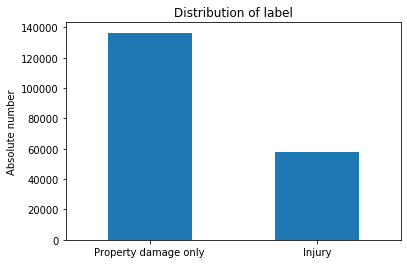

Property damage only    0.701099
Injury                  0.298901
Name: Y_SEVERITYCODE, dtype: float64


In [35]:
df_1.Y_SEVERITYCODE.value_counts().plot(kind='bar')
plt.title('Distribution of label')
plt.xlabel('')
plt.ylabel('Absolute number')
plt.xticks(rotation=0)
plt.show()
print(df_1.Y_SEVERITYCODE.value_counts(normalize=True))

As displayed in the graph above, the chosen dataset presents as a real-world dataset and therefore reveals by being **imbalanced** a common data science problem. While the **majority** of the 194,673 reported collision are **property damage only** (70.11 %). Many models do struggle with identifying the minority classes thus a pre-processing step to overcome this challenge should be implemented. A possible approach is to simply undersample the majority class which is in the context of the large dataset an adequate option but still losing statistical power. Another method is directly integrated in the modelling algorithm by SciKit Learn’s where a **weight** can be added to the minority category. The latter method was chosen due to its good performance and preventing undersampling biases and will be implemented when building the model.

In [36]:
df_1.corr(method='pearson')

,PERSONCOUNT,VEHCOUNT
PERSONCOUNT,1.000000,0.380523
VEHCOUNT,0.380523,1.000000


In [37]:
df_1.describe(include='all')

,PERSONCOUNT,VEHCOUNT,Y_SEVERITYCODE,JUNCTION,WEATHERCOND_1,ROADCOND_1,LIGHTCOND_1,PED,BYC
count,194673.000000,194673.000000,194673,194673,194673,194673,194673,194673,194673
unique,NaN,NaN,2,2,5,3,4,2,2
top,NaN,NaN,Property damage only,N,Clear,Dry,Daylight,N,N
freq,NaN,NaN,136485,102775,111135,124510,116137,187734,189189
mean,2.444427,1.920780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.345929,0.631047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When having a closer look to the numerical values a mean involvement of **2.44 persons** and **1.92 vehicles** could be obtained. Most of the collisions lead to property damage only, did not involve pedestrians nor bicycles, and did not take place in relation to a junction. The most often circumstances involved **clear weather conditions**, a **dry road** and **daylight**.

In [38]:
df_1.groupby('Y_SEVERITYCODE').describe()

PERSONCOUNT                                          \
                           count      mean       std  min  25%  50%  75%   
Y_SEVERITYCODE                                                             
Injury                   58188.0  2.714357  1.544786  0.0  2.0  2.0  3.0   
Property damage only    136485.0  2.329348  1.233759  0.0  2.0  2.0  3.0   

                            VEHCOUNT                                          \
                       max     count      mean       std  min  25%  50%  75%   
Y_SEVERITYCODE                                                                 
Injury                81.0   58188.0  1.867928  0.747174  0.0  1.0  2.0  2.0   
Property damage only  57.0  136485.0  1.943312  0.572966  0.0  2.0  2.0  2.0   

                            
                       max  
Y_SEVERITYCODE              
Injury                11.0  
Property damage only  12.0

In [130]:
Persons_1 = df_1.query("Y_SEVERITYCODE == 'Injury'")
Persons_1 = Persons_1['PERSONCOUNT']

Persons_2 = df_1.query("Y_SEVERITYCODE == 'Property damage only'")
Persons_2 = Persons_2['PERSONCOUNT']

stats.mannwhitneyu(Persons_1, Persons_2)

MannwhitneyuResult(statistic=3293827850.0, pvalue=0.0)

In [131]:
Vehicles_1 = df_1.query("Y_SEVERITYCODE == 'Injury'")
Vehicles_1 = Vehicles_1['VEHCOUNT']

Vehicles_2 = df_1.query("Y_SEVERITYCODE == 'Property damage only'")
Vehicles_2 = Vehicles_2['VEHCOUNT']

stats.mannwhitneyu(Vehicles_1, Vehicles_2)

MannwhitneyuResult(statistic=3615230799.5, pvalue=0.0)

When grouping the amount of involved persons and vehicles by the collision severity, a group difference could be detected via **Mann-Whitney-U-Test**.

In [39]:
cat=['JUNCTION','WEATHERCOND_1', 'ROADCOND_1', 'LIGHTCOND_1', 'PED', 'BYC', 'Y_SEVERITYCODE']
df_1_=df_1[cat]

In [40]:
for column in df_1_.iloc[:,:-1]:
    crosstab_ = pd.crosstab(df_1_[column], df_1_.Y_SEVERITYCODE, margins = True, margins_name='Total')
    print(crosstab_, nl)
    crosstab__ = pd.crosstab(df_1_[column], df_1_.Y_SEVERITYCODE, normalize='columns', margins=True, margins_name='Total')
    print(crosstab__, nl)
    chi2,p,dof,expected = stats.chi2_contingency(crosstab_)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

Y_SEVERITYCODE  Injury  Property damage only   Total
JUNCTION                                            
N                38161                 64614  102775
Y                20027                 71871   91898
Total            58188                136485  194673 

Y_SEVERITYCODE    Injury  Property damage only     Total
JUNCTION                                                
N               0.655823              0.473415  0.527937
Y               0.344177              0.526585  0.472063 

Chi2 value= 5446.500622355916
p-value= 0.0
Degrees of freedom= 4

Y_SEVERITYCODE         Injury  Property damage only   Total
WEATHERCOND_1                                              
Clear                   35840                 75295  111135
Cloudy                   8748                 18971   27719
Other                    2031                 19029   21060
Precipitation           11375                 22790   34165
Restricted visibility     194                   400     594
Total            

When grouping the categorical variables by the collision severity a **group difference** could be detected via chi2-testing in **all** of the attributes.

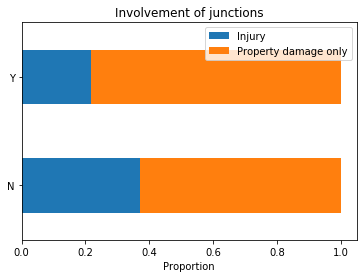

In [41]:
table2=pd.crosstab(df_1.JUNCTION,df_1.Y_SEVERITYCODE)
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)
plt.title('Involvement of junctions')
plt.xlabel('Proportion')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right')

plt.show()

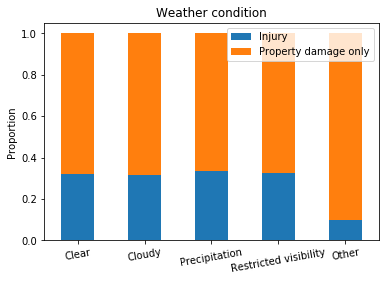

In [42]:
table2=pd.crosstab(df_1.WEATHERCOND_1,df_1.Y_SEVERITYCODE)
Weather_Order = ['Clear','Cloudy', 'Precipitation', 'Restricted visibility', 'Other']
table2 = table2.loc[Weather_Order]
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Weather condition')
plt.xlabel('')
plt.ylabel('Proportion')
plt.xticks(rotation=10)
plt.legend(title='', loc='upper right')

plt.show()

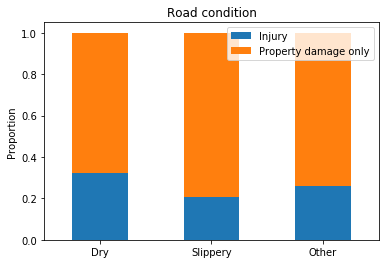

In [43]:
table2=pd.crosstab(df_1.ROADCOND_1,df_1.Y_SEVERITYCODE)
ROAD_Order = ['Dry','Slippery', 'Other']
table2 = table2.loc[ROAD_Order]
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Road condition')
plt.xlabel('')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right')

plt.show()

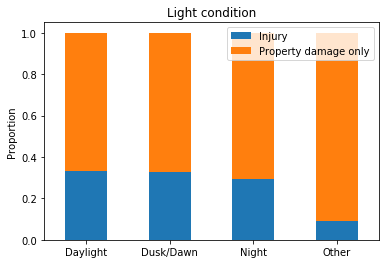

In [44]:
table2=pd.crosstab(df_1.LIGHTCOND_1,df_1.Y_SEVERITYCODE)
LIGHT_Order = ['Daylight','Dusk/Dawn', 'Night', 'Other']
table2 = table2.loc[LIGHT_Order]
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Light condition')
plt.xlabel('')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right')

plt.show()

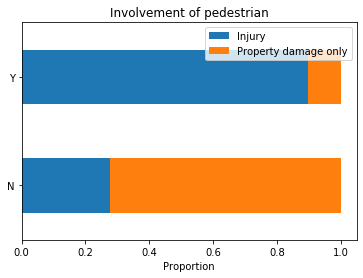

In [45]:
table2=pd.crosstab(df_1.PED,df_1.Y_SEVERITYCODE)
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)
plt.title('Involvement of pedestrian')
plt.xlabel('Proportion')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right')

plt.show()

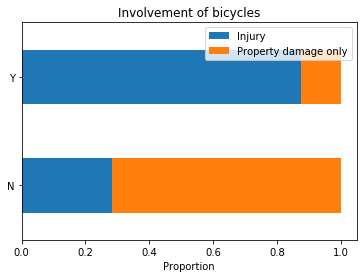

In [46]:
table2=pd.crosstab(df_1.BYC,df_1.Y_SEVERITYCODE)
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)
plt.title('Involvement of bicycles')
plt.xlabel('Proportion')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right')

plt.show()

With these graphical illustration in mind, the clear impact of **involved pedestrians or bicycles** on the collision severity was outstanding. 

## Results

To find attributes to predict traffic collision severity there are several approaches for modelling. As regression provides additional information on the impact of the respective factor, it was the method of choice to enable decision-makers not only to predict the severity but also to take decisions regarding most effective prevention measures. All of the chosen attributes showed a significant group difference regarding traffic collision severity. For further predicting the severity thus enabling stakeholders to categorize the collision and distribute resources, a regression model was built.

### Modeling

When taking categorical variables as potential influencing factors for predicting these need to be turned into **indicator variables** ('dummys'). As a second step the **Sklearn algorithm** for logistic regression was used. Two different approaches were chosen, one to **balance the dataset (LR)**, the other without balancing (LR1). As a solver ‘sag’ was chosen to sufficiently address multiclass problems and the large dataset. The regularization strength was set to 0.01, and the dataset was split into training and testing by 0.2. 

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [47]:
df_1.dtypes

PERSONCOUNT        int64
VEHCOUNT           int64
Y_SEVERITYCODE    object
JUNCTION          object
WEATHERCOND_1     object
ROADCOND_1        object
LIGHTCOND_1       object
PED               object
BYC               object
dtype: object

In [51]:
df_1.columns

Index(['PERSONCOUNT', 'VEHCOUNT', 'Y_SEVERITYCODE', 'JUNCTION',
       'WEATHERCOND_1', 'ROADCOND_1', 'LIGHTCOND_1', 'PED', 'BYC'],
      dtype='object')

In [71]:
Col = ['JUNCTION', 'WEATHERCOND_1', 'ROADCOND_1' , 'LIGHTCOND_1', 'PED', 'BYC', 'Y_SEVERITYCODE']
df_1_dummies = pd.get_dummies(data=df_1, columns=Col)
df_1_dummies.columns

Index(['PERSONCOUNT', 'VEHCOUNT', 'JUNCTION_N', 'JUNCTION_Y',
       'WEATHERCOND_1_Clear', 'WEATHERCOND_1_Cloudy', 'WEATHERCOND_1_Other',
       'WEATHERCOND_1_Precipitation', 'WEATHERCOND_1_Restricted visibility',
       'ROADCOND_1_Dry', 'ROADCOND_1_Other', 'ROADCOND_1_Slippery',
       'LIGHTCOND_1_Daylight', 'LIGHTCOND_1_Dusk/Dawn', 'LIGHTCOND_1_Night',
       'LIGHTCOND_1_Other', 'PED_N', 'PED_Y', 'BYC_N', 'BYC_Y',
       'Y_SEVERITYCODE_Injury', 'Y_SEVERITYCODE_Property damage only'],
      dtype='object')

In [72]:
df_1_dummies=df_1_dummies.drop(['JUNCTION_N','WEATHERCOND_1_Clear','ROADCOND_1_Dry','LIGHTCOND_1_Daylight',
                               'PED_N','BYC_N','Y_SEVERITYCODE_Property damage only'],  axis=1)
df_1_dummies.columns

Index(['PERSONCOUNT', 'VEHCOUNT', 'JUNCTION_Y', 'WEATHERCOND_1_Cloudy',
       'WEATHERCOND_1_Other', 'WEATHERCOND_1_Precipitation',
       'WEATHERCOND_1_Restricted visibility', 'ROADCOND_1_Other',
       'ROADCOND_1_Slippery', 'LIGHTCOND_1_Dusk/Dawn', 'LIGHTCOND_1_Night',
       'LIGHTCOND_1_Other', 'PED_Y', 'BYC_Y', 'Y_SEVERITYCODE_Injury'],
      dtype='object')

#### Training

In [76]:
X = np.asarray(df_1_dummies[['PERSONCOUNT', 'VEHCOUNT', 'JUNCTION_Y','WEATHERCOND_1_Cloudy', 
                             'WEATHERCOND_1_Other','WEATHERCOND_1_Precipitation', 
                             'WEATHERCOND_1_Restricted visibility','ROADCOND_1_Other', 'ROADCOND_1_Slippery', 
                             'LIGHTCOND_1_Dusk/Dawn','LIGHTCOND_1_Night', 'LIGHTCOND_1_Other', 'PED_Y', 
                             'BYC_Y']])
y = np.asarray(df_1_dummies['Y_SEVERITYCODE_Injury'])

array([1, 0, 0, ..., 1, 1, 0], dtype=uint8)

In [77]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (155738, 14) (155738,)
Test set: (38935, 14) (38935,)


In [102]:
LR = LogisticRegression(C=0.01, solver='sag', class_weight='balanced').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
LR1 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LR1

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

#### Testing

In [104]:
yhat = LR.predict(X_test)
yhat

array([0, 1, 0, ..., 1, 1, 0], dtype=uint8)

In [105]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.53, 0.47],
       [0.49, 0.51],
       [0.66, 0.34],
       ...,
       [0.49, 0.51],
       [0.49, 0.51],
       [0.51, 0.49]])

In [106]:
yhat1 = LR1.predict(X_test)
yhat1

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [107]:
yhat_prob1 = LR1.predict_proba(X_test)
yhat_prob1

array([[0.73, 0.27],
       [0.69, 0.31],
       [0.82, 0.18],
       ...,
       [0.69, 0.31],
       [0.69, 0.31],
       [0.7 , 0.3 ]])

#### Evaluation

The following evaluation metrics were obtained for the respective model. As assumed the balanced dataset performed **better prediction of true positive (true injury) values** while losing precision. As it is crucial to correctly predict the collision with injury while it is acceptable to include a larger number of false positive injury-labelled collisions, the balanced model was chosen as the final model to predict traffic collision severity.

In [108]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.6456144856812637

In [109]:
jaccard_similarity_score(y_test, yhat1)

0.7535893155258765

In [110]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 7461  4049]
 [ 9749 17676]]


Confusion matrix, without normalization
[[ 7461  4049]
 [ 9749 17676]]


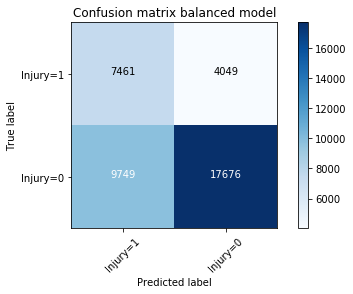

In [133]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Injury=1','Injury=0'],normalize= False,  title='Confusion matrix balanced model')

Confusion matrix, without normalization
[[ 2502  9008]
 [  586 26839]]


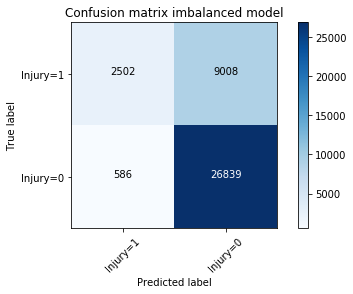

In [134]:
cnf_matrix = confusion_matrix(y_test, yhat1, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Injury=1','Injury=0'],normalize= False,  title='Confusion matrix imbalanced model')

In [113]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5976812741869132

In [114]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob1)

0.5258418312776298

In [115]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72     27425
           1       0.43      0.65      0.52     11510

    accuracy                           0.65     38935
   macro avg       0.62      0.65      0.62     38935
weighted avg       0.70      0.65      0.66     38935



In [116]:
print (classification_report(y_test, yhat1))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     27425
           1       0.81      0.22      0.34     11510

    accuracy                           0.75     38935
   macro avg       0.78      0.60      0.60     38935
weighted avg       0.77      0.75      0.70     38935



In [125]:
d = {'Model': ['Balanced', 'Unbalanced'], 'Log loss': [0.60, 0.53], 'Jaccard similarity score':[0.65, 0.75],
     'Precision for minority category': [0.43, 0.81],
     'Recall for minority category': [0.65, 0.22], 'F1-Score for minority category': [0.52, 0.34]}

Summary = pd.DataFrame(data=d)
Summary = Summary.set_index('Model')
Summary

,Log loss,Jaccard similarity score,Precision for minority category,Recall for minority category,F1-Score for minority category
Model,,,,,
Balanced,0.60,0.65,0.43,0.65,0.52
Unbalanced,0.53,0.75,0.81,0.22,0.34


## Conclusion

As outlined in the introduction, the prediction of traffic collision severity is crucial to **successfully distribute limited health care resources**. The developed model focuses on predicting the severity (Property damage only versus injury) using attributes which can be obtained through first information. Via a logistic regression algorithm, the severity can be predicted and the final model ensures that **the number of incorrectly labelled collisions as 'property damage only' are minimized while it accepts a higher number of incorrectly more severe labelled collisions**.   
Furthermore, the attributes chosen are all relevant factors of traffic collision severity, thus being targets of further prevention strategies.
Such a model needs to be revised thoroughly as it may lead to important decisions taken by health care managers. The presented model is a draft which definitely should not be used for far-reaching decisions which affect the health provision in emergency settings. It needs to be finalized and iteratively evaluated.
